In [1]:
import torch
from torch import nn
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import os
import glob
from PIL import Image

import cv2

In [2]:
# from IPython.display import display, IFrame

# full_width = True
# frame_height = 720  # adjust for your screen

# url = "https://minhaskamal.github.io/DownGit/#/home"
# IFrame(src=url, width='100%', height=frame_height)

# Download the Data

- we can download the data with `git clone 'url'` or with the Code in the second Cell

In [3]:
!git clone "https://github.com/Bjarten/computer-vision-ND/tree/master/project_1_facial_keypoints/data.git"


Cloning into 'data'...
fatal: repository 'https://github.com/Bjarten/computer-vision-ND/tree/master/project_1_facial_keypoints/data.git/' not found


In [4]:
import requests
import zipfile  # because the data is .zip
from pathlib import Path


url = "https://github.com/Bjarten/computer-vision-ND/archive/refs/heads/master.zip"

#set up a path to a data folder
data_path = Path()
image_path = data_path / "data"

# if the image folder doesn't exist, download it nad prepare it...
if image_path.is_dir():
  print(f'{image_path} directory already exists')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / "data.zip", 'wb') as f:
  request = requests.get(url)
  print("Downloading the data...")
  f.write(request.content)

# unzip the file
with zipfile.ZipFile(data_path/'data.zip', 'r') as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(image_path)

data does not exist, creating one...
Unzipping data...


In [5]:
import shutil
shutil.move('data/computer-vision-ND-master/project_1_facial_keypoints/data/','Data')
shutil.rmtree('data')# to remove a directory if it is not empty else-> os.rmdir('')

# Read the Data

## Preparing the Paths

In [6]:
data_path = Path('Data')
test_path = data_path/'test'
train_path = data_path/'training'

test_keypoints = pd.read_csv(data_path/'test_frames_keypoints.csv')
train_keypoints = pd.read_csv(data_path/'training_frames_keypoints.csv')


## Creating a Dataset Class

In [7]:
class FacialKeypointsClass(Dataset):
  def __init__(self, root, csv_file, transform=None) -> None:
    '''
    Args:
      root: (string) data_path
      csv_file: (Pandas Frame) Keypoints Frame
      transform: (optional) it must be a custom transform
    '''
    super().__init__()
    self.root = root
    self.keypoints_file = csv_file
    self.transform = transform
    
  def __len__(self):
    return len(self.keypoints_file)

  def __getitem__(self, index):
    image_name = self.keypoints_file.iloc[index,0]
    keypoints = self.keypoints_file.iloc[index,1:].to_numpy().astype('float').reshape(-1,2)

    img_path = os.path.join(self.root, image_name)
    image = mpimg.imread(img_path)

    # if the Images have 4 color channel, we need to change it
    if image.shape[2] > 3:
      image = image[:,:,0:3]

    sample = {'Image': image, 'Keypoints':keypoints}
    if self.transform:
      sample = self.transform(sample)

    return sample

In [8]:
#Check if it works?
train_dataset = FacialKeypointsClass(root=train_path, csv_file=train_keypoints)
len(train_dataset)

3462

### Explore the Data

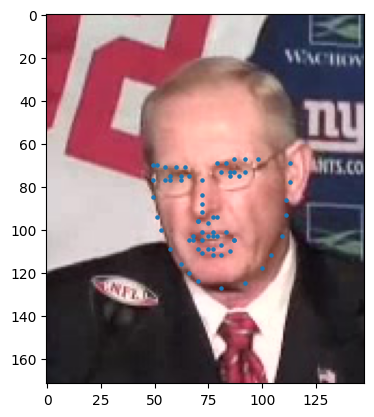

In [9]:
import random
idx = random.randint(0, len(train_dataset))
sample = train_dataset[idx]
image, key_pts = sample['Image'], sample['Keypoints']

plt.imshow(image)
plt.scatter(key_pts[:,0], key_pts[:,1], s=20, marker='.')

## Creating Transforms Classes

In [10]:
class Normalize(object):
  '''Convert a color image to grayscale and normalize the color range to [-1:1]'''
  def __call__(self, sample):
    image, key_pts = sample['Image'], sample['Keypoints']
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = gray/255.0

    key_pts = (key_pts - 122) / 122.0

    return {'Image':gray, 'Keypoints':key_pts}

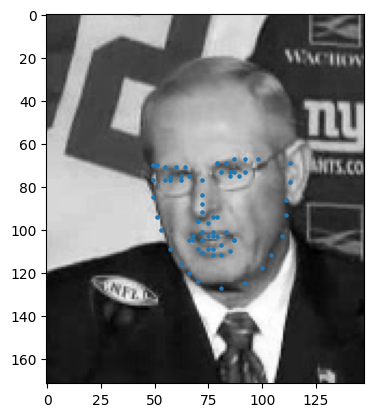

In [11]:
transform = transforms.Compose([Normalize()])
transformed_s = transform(sample)
image_s, kpts = transformed_s['Image'], transformed_s['Keypoints']

plt.imshow(image_s, cmap='gray')

# to unnormalize the keypoints
kpts = (kpts* 122)+122
plt.scatter(kpts[:,0], kpts[:,1], s=20, marker='.')

In [12]:
class ToTensor(object):
  '''Convert the Images and Keypoints from Numpy to Tensor'''
  def __call__(self, sample):
    img, kpts = sample['Image'], sample['Keypoints']

    if len(img.shape) == 2:
      img = img.reshape(img.shape[0], img.shape[1], 1)
    # to change  H W C to C W H
    img = torch.from_numpy(img).permute([2,0,1])

    return {'Image': img, 'Keypoints': torch.from_numpy(kpts)}


In [13]:
class FaceCrop(object):
    """ Crop out face using the keypoints as reference

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """       
        
    def __call__(self, sample):
        image, key_pts = sample['Image'], sample['Keypoints']

        image_copy = np.copy(image)
        
        h, w = image.shape[:2]
        
        x_max = 0
        x_min = 10000
        y_max = 0
        y_min = 10000
        
        # Find the coordinates to keypoints at the far left, far right, top and bottom
        # Also check that no keypoints are outside the image
        for coord in key_pts:
            if coord[0] > x_max:
                if coord[0] >= w:
                    x_max = w
                else:
                    x_max = coord[0]
            if coord[0] < x_min:
                if coord[0] < 0:
                    x_min = 0
                else:
                    x_min = coord[0]
            if coord[1] > y_max:
                if coord[1] >= h:
                    y_max = h
                else:
                    y_max = coord[1]
            if coord[1] < y_min:
                if coord[1] < 0:
                    y_min = 0
                else:
                    y_min = coord[1]
        
        # Set the the left corner keypoint as out crop cooridnate
        x = int(x_min)
        y = int(y_min)
        
        # Get height and width of keypoint area
        new_h = int(y_max - y_min)
        new_w = int(x_max - x_min)
        
        #Set the smallest side equal to the largest since we want a square
        if new_h > new_w:
            new_w = new_h
        else:
            new_h = new_w       
        
        randsize1 = [2, 70]
        randsize2 = [2, 30]
        randsize3 = [1, 10]

        # Check that padding dosent go outside the frame
        padding_x_1 = 0
        padding_x_2 = 0
        padding_y_1 = 0
        padding_y_2 = 0
        
        padding_size_x_1 = random.randint(randsize1[0],randsize1[1])
        padding_size_x_2 = random.randint(randsize1[0],randsize1[1])
        padding_size_y_1 = random.randint(randsize1[0],randsize1[1])
        padding_size_y_2 = random.randint(randsize1[0],randsize1[1])
        if(y - padding_size_y_1 > 0 and x - padding_size_x_1 > 0
           and x + new_w + padding_size_x_2 < w and y + new_h + padding_size_y_2 < h):
            padding_x_1 = padding_size_x_1
            padding_x_2 = padding_size_x_2
            padding_y_1 = padding_size_y_1
            padding_y_2 = padding_size_y_2
        else:
            padding_size_x_1 = random.randint(randsize2[0],randsize2[1])
            padding_size_x_2 = random.randint(randsize2[0],randsize2[1])
            padding_size_y_1 = random.randint(randsize2[0],randsize2[1])
            padding_size_y_2 = random.randint(randsize2[0],randsize2[1])
         
            if(y - padding_size_y_1 > 0 and x - padding_size_x_1 > 0
               and x + new_w + padding_size_x_2 < w and y + new_h + padding_size_y_2 < h):
                padding_x_1 = padding_size_x_1
                padding_x_2 = padding_size_x_2
                padding_y_1 = padding_size_y_1
                padding_y_2 = padding_size_y_2
                
            else:
                padding_size_x_1 = random.randint(randsize3[0],randsize3[1])
                padding_size_x_2 = random.randint(randsize3[0],randsize3[1])
                padding_size_y_1 = random.randint(randsize3[0],randsize3[1])
                padding_size_y_2 = random.randint(randsize3[0],randsize3[1])
         
                if(y - padding_size_y_1 > 0 and x - padding_size_x_1 > 0
                   and x + new_w + padding_size_x_2 < w and y + new_h + padding_size_y_2 < h):
                    padding_x_1 = padding_size_x_1
                    padding_x_2 = padding_size_x_2
                    padding_y_1 = padding_size_y_1
                    padding_y_2 = padding_size_y_2 
        
        
        image_copy = image_copy[y - padding_y_1: y + new_h + padding_y_2, x - padding_x_1: x + new_w + padding_x_2]     
        
        key_pts = key_pts - [x - padding_x_1, y - padding_y_1] 
        
        return {'Image': image_copy, 'Keypoints': key_pts}


In [14]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['Image'], sample['Keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'Image': img, 'Keypoints': key_pts}

In [15]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['Image'], sample['Keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'Image': image, 'Keypoints': key_pts}

(80, 94, 3) (175, 173, 3)


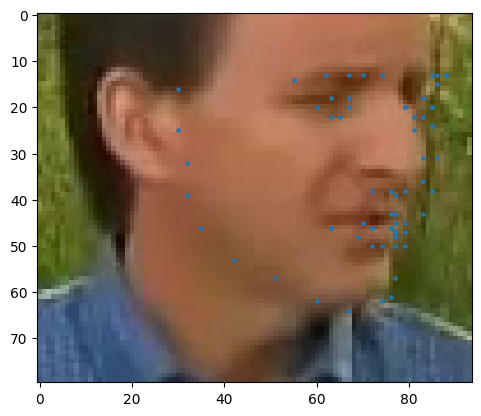

In [16]:
transform = transforms.Compose([FaceCrop()])
sample = train_dataset[515]
transformed_s = transform(sample)
image_s, kpts = transformed_s['Image'], transformed_s['Keypoints']
print(image_s.shape, sample['Image'].shape)
plt.imshow(image_s, cmap='gray')

# to unnormalize the keypoints
# kpts = (kpts* 122)+122
plt.scatter(kpts[:,0], kpts[:,1], s=20, marker='.')

## Getting all Together and Creating our Transform

In [17]:
transform = transforms.Compose([FaceCrop(),
                                Rescale((224,224)),
                                Normalize(),
                                ToTensor()])

## Preparing the Model

we loading a pretraind model. Then we change the output shape to `136` (the Number of the Facialkeypoints)

In [18]:
model = models.resnet50(weights=models.ResNet50_Weights)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
model.fc = torch.nn.Linear(in_features=2048, out_features=136, bias=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [20]:
train_dataset = FacialKeypointsClass(root=train_path,
                                     csv_file=train_keypoints,
                                     transform=transform)
test_dataset = FacialKeypointsClass(root=test_path, 
                                    csv_file=test_keypoints,
                                    transform=transform)

len(train_dataset), len(test_dataset)

(3462, 770)

In [21]:
train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=64)
test_dataloader = DataLoader(dataset=test_dataset,
                             shuffle=True,
                             batch_size=64)

In [22]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(lr=0.1, params=model.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500],gamma=0.5)

### Creating a train & test Step

In [23]:
class EarlyStopping:
    """Early stops the training if validation loss dosen't improve after a given patience."""
    def __init__(self,patience=7):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved. 
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
    
    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''

        save_models_path = data_path / "saved_models"
        if not save_models_path.is_dir():
          save_models_path.mkdir(parents=True, exist_ok=True)

        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'Data/saved_models/checkpoint.pt')
        self.val_loss_min = val_loss

In [24]:
def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device: torch.device='cpu'):
  train_loss, running_train_loss = 0, 0
  model.train()
  for batch, data in enumerate(dataloader):

    keypoints = data['Keypoints']
    images = data['Image']


    # flatten pts
    keypoints = keypoints.view(keypoints.size(0), -1)

    # convert variables to floats for regression loss
    keypoints = keypoints.type(torch.FloatTensor)
    images = images.type(torch.FloatTensor)

    keypoints, images = keypoints.to(device), images.to(device)

    # flatten pts
    keypoints = keypoints.view(keypoints.size(0), -1)

    # 01. Optimizer Zero Grad
    optimizer.zero_grad()

    #02. Forward Pass
    predicted = model(images)

    predicted = predicted.view(predicted.size(0), -1)

    #03. Calculate the Loss
    loss = loss_fn(predicted, keypoints)

    train_loss += loss

    #04. Backward Pass
    loss.backward()

    #05. Update the Weights
    optimizer.step()

    
    # print loss statistics
    # to convert loss into a scalar and add it to the running_loss, use .item()
    running_train_loss += loss.item()
    if batch % 10 == 9 or batch == 0:    # print every 10 batches
        if batch == 0:
            avg_train_loss = running_train_loss
        else:
            avg_train_loss = running_train_loss/10
        train_loss_over_time.append(avg_train_loss)
        running_train_loss = 0.0

  train_loss /= len(dataloader)

  return train_loss

In [25]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = 'cpu'):
    
    model.eval()
    test_loss = 0

    with torch.inference_mode():
        for data in dataloader:
          keypoints, images = data['Keypoints'], data['Image']

          # flatten pts
          keypoints = keypoints.view(keypoints.size(0), -1)

          # convert variables to floats for regression loss
          keypoints = keypoints.type(torch.FloatTensor).to(device)
          images = images.type(torch.FloatTensor).to(device)

          #01. Forward Pass
          predicted = model(images)

          #02. Calculate the Loss
          loss = loss_fn(predicted.view(predicted.size(0), -1), keypoints)

          test_loss += loss
        test_loss /= len(dataloader)
    return test_loss


In [26]:
from tqdm.auto import tqdm

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 || Train MSE Loss : 0.05699 || Test MSE Loss : 0.10159


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2 || Train MSE Loss : 0.04243 || Test MSE Loss : 0.05534
Validation loss decreased (inf --> 0.055336).  Saving model ...
Epoch 3 || Train MSE Loss : 0.03420 || Test MSE Loss : 0.03372
Validation loss decreased (0.055336 --> 0.033718).  Saving model ...
Epoch 4 || Train MSE Loss : 0.02835 || Test MSE Loss : 0.04396
EarlyStopping counter: 1 out of 7
Epoch 5 || Train MSE Loss : 0.02342 || Test MSE Loss : 0.02205
Validation loss decreased (0.033718 --> 0.022052).  Saving model ...
Epoch 6 || Train MSE Loss : 0.01952 || Test MSE Loss : 0.02073
Validation loss decreased (0.022052 --> 0.020726).  Saving model ...
Epoch 7 || Train MSE Loss : 0.01664 || Test MSE Loss : 0.02263
EarlyStopping counter: 1 out of 7
Epoch 8 || Train MSE Loss : 0.01523 || Test MSE Loss : 0.01478
Validation loss decreased (0.020726 --> 0.014783).  Saving model ...
Epoch 9 || Train MSE Loss : 0.01393 || Test MSE Loss : 0.01573
EarlyStopping counter: 1 out of 7
Epoch 10 || Train MSE Loss : 0.01229 || Test MSE Loss 

Text(0.5, 1.0, 'Loss')

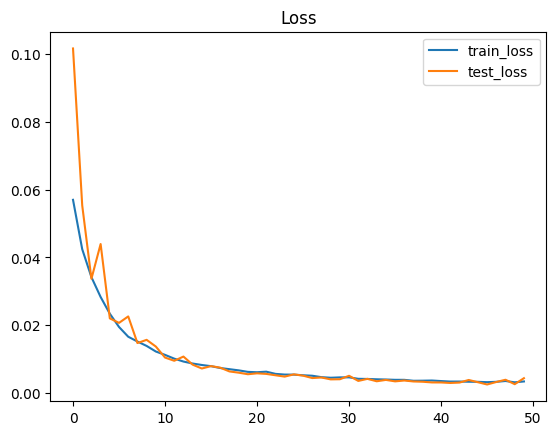

In [28]:
epochs = 50
train_loss_list, test_loss_list = [], []

train_loss_over_time = [] # to track the loss as the network trains
val_loss_over_time = [] # to track the validation loss as the network trains

early_stopping = EarlyStopping()

for epoch in tqdm(range(epochs)):
  train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device=device)
  test_loss = test_step(model, test_dataloader, loss_fn, device=device)

  train_loss_list.append(train_loss.cpu().detach().numpy())
  test_loss_list.append(test_loss.cpu().detach().numpy())

  print(f'Epoch {epoch+1} || Train MSE Loss : {train_loss:.5f} || Test MSE Loss : {test_loss:.5f}')

  # reduce learning rate when test_loss has stopped improving
  scheduler.step(test_loss)

  early_stopping(test_loss, model)

  if early_stopping.early_stop:
      # remove data collected after last checkpoint
      train_loss_over_time = train_loss_over_time[:-early_stopping.patience]
      val_loss_over_time = val_loss_over_time[:-early_stopping.patience]
      print("Early stopping")
      break

plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()
plt.title('Loss')

In [41]:
#load the best Model
model.load_state_dict(torch.load('Data/saved_models/checkpoint.pt'))

<All keys matched successfully>

In [122]:
def show_keypoint(images, keypoints, predicted_kp, k = 9):
  plt.figure(figsize=(15,10))
  predicted_kp = predicted_kp.reshape(64,-1,2)
  for i, image in enumerate(images):
    ax = plt.subplot(3, 5, i+1)
    ax.imshow(image, cmap='gray')
    if keypoints is not None:
      #unnormalize the Keypoints
      kp = (keypoints[i]*122)+122
      ax.scatter(kp[:,0], kp[:,1],marker='.',c='r', s=15)

    if predicted_kp is not None:
      p_kp = (predicted_kp[i]*122)+122
      ax.scatter(p_kp[:,0], p_kp[:,1], marker='.', c='g', s=15)
    if i == k:
      break

In [120]:
model.eval()

for data in test_dataloader:
  image = data['Image'].type(torch.FloatTensor).to(device)
  keypoints = data['Keypoints'].type(torch.FloatTensor).to(device)
  output = model(image)
  break

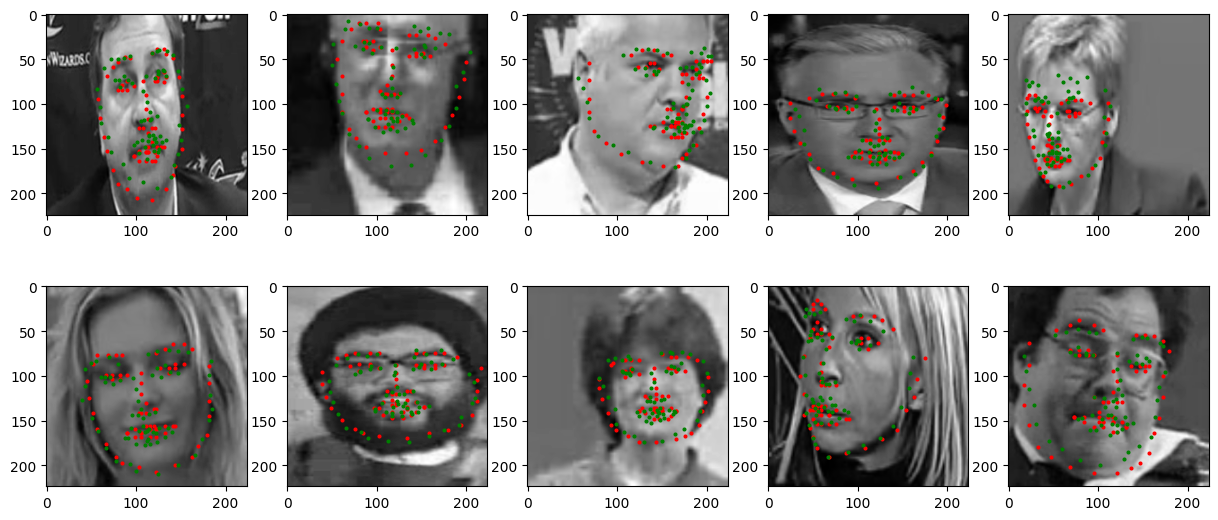

In [123]:
show_keypoint(image.squeeze(1).cpu().detach().numpy(), keypoints.cpu().detach().numpy(), output.cpu().detach().numpy())